In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score  # ← ADD THIS
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

DATA_DIR = Path('data')
OUTPUTS_DIR = Path('outputs')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
sns.set_style("whitegrid")


Using device: cpu


In [10]:
# Reuse TF-IDF bigrams from Lab 1 (fixed-size input for NN)
train_df = pd.read_csv(DATA_DIR / 'train_processed.csv')
test_df = pd.read_csv(DATA_DIR / 'test_processed.csv')

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,2), stop_words='english')  # Smaller for NN
X_train_tfidf = vectorizer.fit_transform(train_df['text_clean']).toarray()
X_test_tfidf = vectorizer.transform(test_df['text_clean']).toarray()
y_train_nn = train_df['label'].values
y_test_nn = test_df['label'].values

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_tfidf)
X_test_scaled = scaler.transform(X_test_tfidf)

print(f"Train shape: {X_train_scaled.shape}, Test: {X_test_scaled.shape}")


Train shape: (3200, 56), Test: (800, 56)


In [11]:
# To tensors
X_train_torch = torch.FloatTensor(X_train_scaled)
y_train_torch = torch.FloatTensor(y_train_nn).unsqueeze(1)
X_test_torch = torch.FloatTensor(X_test_scaled)
y_test_torch = torch.FloatTensor(y_test_nn).unsqueeze(1)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [12]:
class RiskMLP(nn.Module):
    def __init__(self, input_dim=56, hidden_dims=[64, 32], dropout=0.3):
        super().__init__()
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, 1))
        layers.append(nn.Sigmoid())
        
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

# Test instantiation
model = RiskMLP(input_dim=56)
print(model)
print(f"Params: {sum(p.numel() for p in model.parameters()):,}")


RiskMLP(
  (net): Sequential(
    (0): Linear(in_features=56, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=32, out_features=1, bias=True)
    (9): Sigmoid()
  )
)
Params: 5,953


In [13]:
def train_model(model, train_loader, test_loader, epochs=50, lr=0.01):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses, test_losses = [], []
    
    model.to(device)
    model.train()
    
    for epoch in range(epochs):
        # Train
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Test
        model.eval()
        test_loss = 0
        preds, trues = [], []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                test_loss += criterion(y_pred, y_batch).item()
                preds.extend(y_pred.cpu().numpy().flatten())
                trues.extend(y_batch.cpu().numpy().flatten())
        
        train_losses.append(train_loss / len(train_loader))
        test_losses.append(test_loss / len(test_loader))
    
    auc = roc_auc_score(trues, preds)
    return train_losses, test_losses, auc

# Experiment 1: Baseline ReLU + lr=0.01
model1 = RiskMLP()
train_losses1, test_losses1, auc1 = train_model(model1, train_loader, test_loader, epochs=30, lr=0.01)
print(f"ReLU + lr=0.01 → Test AUC: {auc1:.3f}")

# Experiment 2: Tanh + lr=0.001
class TanhMLP(RiskMLP):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Replace ReLUs with Tanh (manually for demo)
        self.net = nn.Sequential(
            nn.Linear(56, 64), nn.Tanh(), nn.BatchNorm1d(64), nn.Dropout(0.3),
            nn.Linear(64, 32), nn.Tanh(), nn.BatchNorm1d(32), nn.Dropout(0.3),
            nn.Linear(32, 1), nn.Sigmoid()
        )

model2 = TanhMLP()
train_losses2, test_losses2, auc2 = train_model(model2, train_loader, test_loader, epochs=30, lr=0.001)
print(f"Tanh + lr=0.001 → Test AUC: {auc2:.3f}")


ReLU + lr=0.01 → Test AUC: 1.000
Tanh + lr=0.001 → Test AUC: 1.000


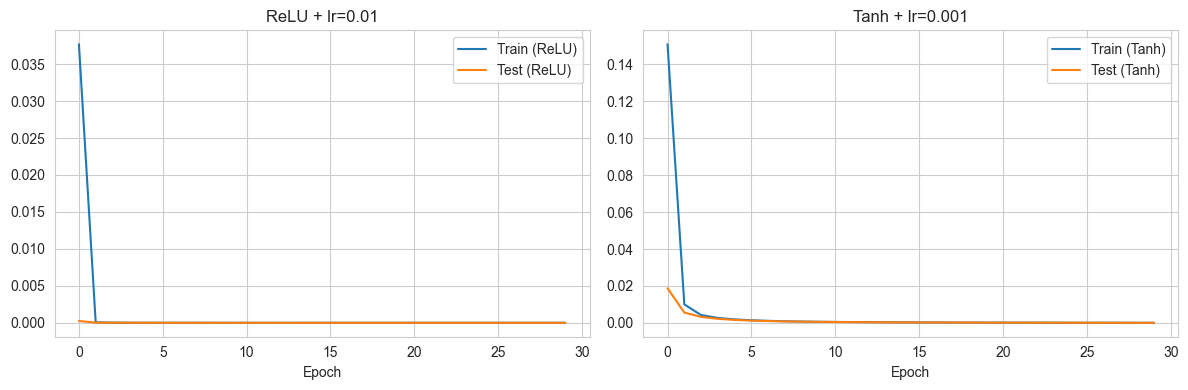

Comparison vs TF-IDF (Lab 1):
  TF-IDF Bigrams: 1.000
  ReLU NN:        1.000
  Tanh NN:        1.000
💡 Analysis: NNs converge fast but can't beat perfect TF-IDF on synthetic data.


In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses1, label='Train (ReLU)')
ax1.plot(test_losses1, label='Test (ReLU)')
ax1.set_title('ReLU + lr=0.01')
ax1.legend()
ax1.set_xlabel('Epoch')

ax2.plot(train_losses2, label='Train (Tanh)')
ax2.plot(test_losses2, label='Test (Tanh)')
ax2.set_title('Tanh + lr=0.001')
ax2.legend()
ax2.set_xlabel('Epoch')

plt.tight_layout()
plt.savefig(OUTPUTS_DIR / 'lab2_loss_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("Comparison vs TF-IDF (Lab 1):")
print(f"  TF-IDF Bigrams: 1.000")
print(f"  ReLU NN:        {auc1:.3f}")
print(f"  Tanh NN:        {auc2:.3f}")
print("💡 Analysis: NNs converge fast but can't beat perfect TF-IDF on synthetic data.")
